# Advertising on iffy newssites

The [Iffy Index of Unreliable Sources](https://iffy.news/index/#methodology) by Media Bias/Fact Check (MBFC) maintains a list of news sites that regularly fail fact-checks and is a widely used research tool in the field of mis/disinformation. The data contains domain names and a compilation of credibility ratings from different sources. The list is compiled by a team of researchers, accepts feedback from publishers and is continually reconsidering past ratings.

It's somewhat common for websites to have an ads.txt (Authorized Digital Sellers) URL when they generate revenue with their file. It specifies a text file that companies can host on their web servers. This file contains information about which advertisers are allowed to operate on the site. By parsing this information for news sites in the dataset we might be able to find interesting relationships between sites' credibility and their advertisements.

In [1]:
import pandas as pd

newssites = pd.read_excel("iffy_index.xlsx")
newssites.head()

,Domain name,MBFC Factual,MBFC Cat,MBFC Cred,Global Site Rank,Wikipedia article,Misinfo.me,Fact-checks
0,100percentfedup.com,L,FN,L,72.284,NaN,-0.91,100 Percent Fed Up
1,10news.one,L,FN,L,"30,000,000",NaN,0.00,10News.one
2,12minutos.com,L,FN,L,276.039,NaN,-1.00,12minutos.com
3,163.com,M,FN,L,309,W,0.23,NetEase
4,1tv.ru,M,FN,L,2.598,W,0.28,Channel One Russia


Misinfo.me rates the sites' credibility from low (-1.0) to high (1.0). To only include the most interesting domain names, we will filter out those that have a negative credibility rating. Next, we will create a new column and add the prefix "https://" to every domain name to be able to use them with the `requests` library. This library is needed to send HTTP requests to the ads.txt URLs. 

In [2]:
newssites = newssites[newssites["Misinfo.me"] <= 0]
newssites["Domain name"] = "https://" + newssites["Domain name"]

## Extracting the data

The Iffy Index was last updated in January 2024, so some of the sites may no longer be functioning. Moreover, not all sites in the dataset will have an ads.txt file. According to IAB Technology Laboratory, who introduced the initiative, 44% of publishers had ads.txt files in 2017 (IAB, 2017). We will send a HTTP request to each domain"s ads.txt URL, and store its text content if available. Ads.txt files are uploaded to the root directory of a website, e.g. *example.com/ads.txt*. 

In [4]:
import requests
import warnings

warnings.filterwarnings("ignore")

def request_adstxt(urls, timeout=10):
    adstxt_files = []

    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
        "Accept":
        "text/plain"
    }

    for url in urls:
        ads_url = f"{url}/ads.txt"
        try:
            response = requests.get(ads_url, headers=headers, timeout=timeout, verify=False)
            if response.status_code == 200:
                text = response.text.lower()
                # Filter out cases where the server returns a HTML error page
                if "hmtl" not in text and "body" not in text and "div" not in text and "span" not in text:
                    adstxt_files.append({"domain": url, "text": text})
        except:
            # If an error occurs, skip the URL
            pass

    return adstxt_files

newssite_urls = newssites["Domain name"].tolist()
adstxt_content = request_adstxt(newssite_urls)

How many of the publishers in the dataset have a functioning news website with an ads.txt URL?

In [7]:
percentage_adstxt = (len(adstxt_content) / len(newssites)) * 100

print("Percentage of domains with a functioning site and ads.txt URL: {:.2f}%".format(percentage_adstxt))

Percentage of domains with a functioning site and ads.txt URL: 63.71%


Ads.txt files need to be a certain format in order for them to be crawled by advertising networks. [Google Adsense](https://support.google.com/adsense/answer/12171612?hl=en) has set up a few formatting guidelines to follow. Each line in the file uses the CSV style formatting, and can have three to four values. Comments are signalled by a # character. We will use a regular expression to extract all of these values from the ads.txt files, excluding any comments.

In [8]:
import re

def parse_adstxt(adstxt_files):
    all_data = []

    for file in adstxt_files:
        # Regex to parse the information in the ads.txt file
        pattern = r"^(?!#)([^,]+),\s*([\w-]+),\s*([a-zA-Z]+)(?:,\s*([\w\d]+))?.*"

        for line in file["text"].split("\n"):
            match = re.match(pattern, line)
            if match:
                ad_network, seller_account_id, account_type, tag_id = match.groups()

                # Check if optional tag_id is present in the line
                if tag_id is None:
                    tag_id = ""

                data = {
                    "Domain name": file["domain"],
                    "Ad network": ad_network,
                    "Seller account ID": seller_account_id,
                    "Account type": account_type,
                    "Tag ID": tag_id
                }
                all_data.append(data)

    df = pd.DataFrame(all_data)
    return df

ads = parse_adstxt(adstxt_content)

We'll save the ads DataFrame to an Excel file in order to not lose any data when variables get reset.

In [3]:
# Save to excel file
ads.to_excel("ads_output.xlsx")
ads = pd.read_excel("ads_output.xlsx")

## Data visualisation

We will count how many times each advertising network is listed in the data. Sometimes ad networks are listed multiple times in one ads.txt file, but with different tag IDs or seller account IDs. Some ads.txt files may also contain typos, like putting the account type value in the tag ID value, misspelling the account type (resellere, resellerr, res) or misspelling the exchange names. This shouldn't influence the results too much however.

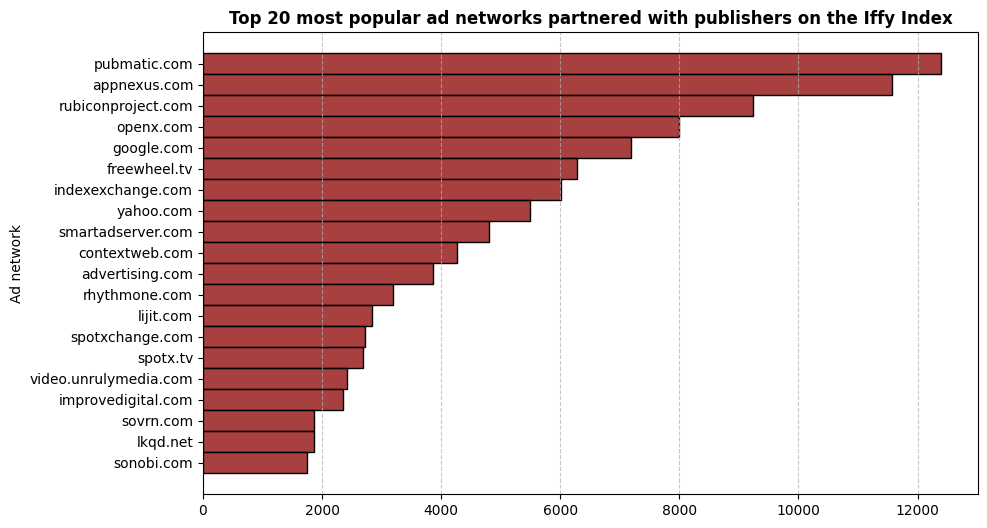

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

top_20_ad_networks = ads["Ad network"].value_counts().head(20)

# Filter the DataFrame to include only the top 20 ad networks
top_20_filtered = ads[ads["Ad network"].isin(top_20_ad_networks.index)]

# Sort the filtered DataFrame by the order of ad networks in top_20_ad_networks
top_20_sorted = top_20_filtered.sort_values(by="Ad network", key=lambda x: x.map(top_20_ad_networks), ascending=False)

plt.figure(figsize=(10, 6))
sns.histplot(data=top_20_sorted, y="Ad network", color="darkred")
plt.title("Top 20 most popular ad networks partnered with publishers on the Iffy Index", fontweight="bold")
plt.ylabel("Ad network")
plt.xlabel("")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Next, we will count the amount of entries in every ads.txt file. Is there a relationship between the amount of advertising partnerships a website has, and the credibility of this site? We'll use the domain's Misinfo.me score, and the category assigned to it by MBFC (either Fake News, Conspiracy/Pseudoscience or Low Credibility). A lower Misinfo.me score means less credibility for the domain.

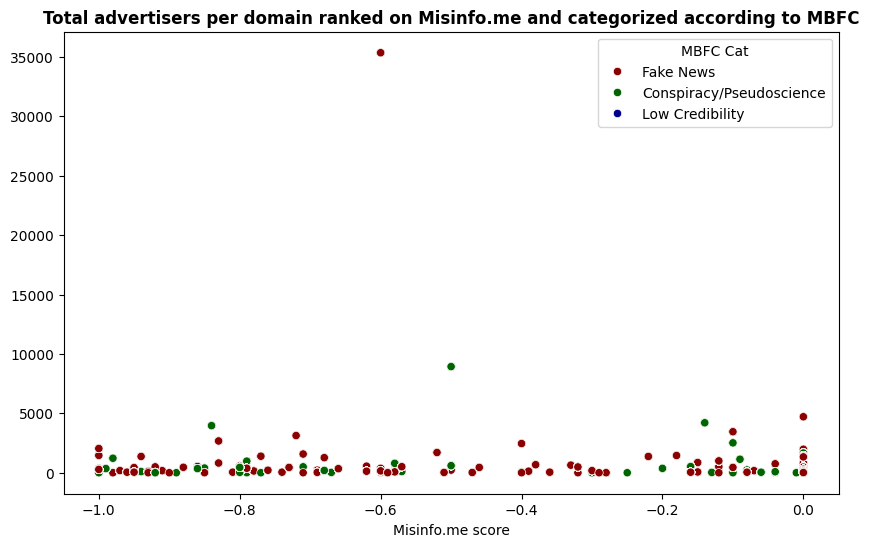

In [5]:
# Merge the two DataFrames
merged_data = pd.merge(ads, newssites, on="Domain name", how="inner")

# Count how many times each domain occurs
most_ads = merged_data.groupby("Domain name").size().reset_index(name="Number of advertisers")

# Add the column 'Number of advertisers'
count_data = pd.merge(most_ads, merged_data, on="Domain name", how="inner")

count_data["MBFC Cat"] = count_data["MBFC Cat"].replace({"FN": "Fake News", "CP": "Conspiracy/Pseudoscience", "LC": "Low Credibility"})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=count_data, x="Misinfo.me", y="Number of advertisers", hue="MBFC Cat", palette={"Fake News": "darkred", "Conspiracy/Pseudoscience": "darkgreen", "Low Credibility": "darkblue"})
plt.title("Total advertisers per domain ranked on Misinfo.me and categorized according to MBFC", fontweight="bold")
plt.xlabel("Misinfo.me score")
plt.ylabel("")
plt.show()

There seems to be one outlier with around 35.000 advertising parterships listed in the ads.txt file. Which domain's is this?

In [6]:
count_data_max = count_data.loc[count_data["Number of advertisers"].idxmax(), "Domain name"]
print("Domain with the largest number of advertising partnerships:", count_data_max)

Domain with the largest number of advertising partnerships: https://thepatriotnation.net


The tag ID in an ads.txt file is an optional field. It identifies the advertising system within a certification authority, usually, the Trustworthy Accountability Group (TAG). It helps advertisers and exchanges verify the legitimacy of the seller. Each tag ID is unique to a particular ad placement (Sweeney, 2023).

If an ads.txt file for a domain contains a large number of the same tag IDs, it could suggest a few possibilities:
- The domain may have a significant partnership or arragement wih a single ad network.
- It could indicate bulk reselling of ad inventory by intermediaries. 

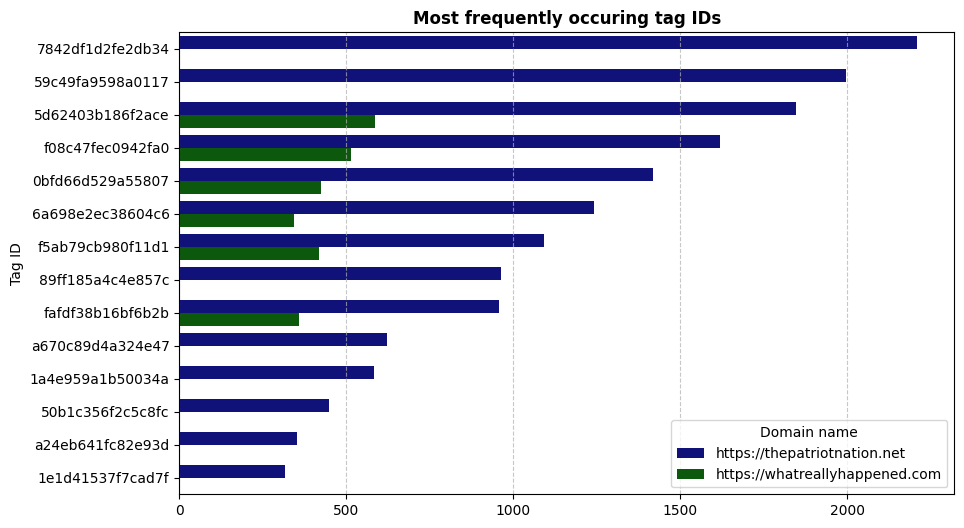

In [7]:
# Count reccuring tag IDs
tag_id_count = merged_data.groupby(["Domain name", "Tag ID"]).size().reset_index(name="Count")

tag_ids_sorted = tag_id_count.sort_values(by="Count", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=tag_ids_sorted, x="Count", y="Tag ID", hue="Domain name", palette={"https://thepatriotnation.net": "darkblue", "https://whatreallyhappened.com": "darkgreen"})
plt.title("Most frequently occuring tag IDs", fontweight="bold")
plt.xlabel("")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Conclusions

1. The most used advertising networks for domains listed on the Iffy Index, are [pubmatic.com](https://pubmatic.com/) and [appnexus.com](https://console.appnexus.com/). Both of these were listed about 12.000 times respectively. The original list of domains contained 1804 entries, and 63,71% of these entries had a working ads.txt URL with their domain name. Other notable advertising networks listed for these unreliable websites were [google.com](https://www.google.com/?hl=nl) and [yahoo.com](https://www.yahoo.com/).

2. There doesn't seem to be any kind of relationship between the credibility of a site and its number of advertising partners. Neither the Misinfo.me score or the category assigned to the domain by MBFC seemed to have any influence on this. The domain with the largest amount of advertising partners was [thepatriotnation.net](https://thepatriotnation.net/), which has been categorized by MBFC as Fake News.

3. The domain [thepatriotnation.net](https://thepatriotnation.net/) also has the most amount of recurring tag IDs, with [whatreallyhappened.com](https://whatreallyhappened.com/NEW/) taking second place.

## Sources

Golding, B. (2024, 7 January). Iffy Index of Unreliable Sources. https://iffy.news/index/#methodology

Ensure your ads.txt files can be crawled - Google AdSense Help. (n.d.). https://support.google.com/adsense/answer/7679060?hl=en

IAB (2017, 1 november). State of Ads.txt Adoption. Ad Ops Insider. https://web.archive.org/web/20180321051456/http://www.adopsinsider.com/ad-exchanges/ads-txt-adoption/

Sweeney, M. (2023, 6 October). What Is app-ads.txt and How Does it Work? Clearcode. https://clearcode.cc/blog/what-is-app-ads-txt/